In [23]:
import core.cg_core
AbstractConjugateGradient = core.core.AbstractConjugateGradient
CGAnalyzer = core.core.CGAnalyzer
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.sparse as sparse
from tqdm import tqdm
from scipy import signal


def ReadImageAsNumpy(file:str):
    img = Image.open(file)
    numpydata = np.asarray(img, dtype=np.float32)
    return numpydata


def BoxBlur(Image:np.ndarray, boxsize=5, boundary="wrap"):
    assert Image.ndim == 2 or Image.ndim == 3, \
         "Should be a matrix, or a 3d tensor. "
    if Image.ndim == 3:
        assert Image.shape[2] == 3, \
            "Image should have 3 color channels on the last axis. "
    Kernel = np.ones((BoxSize, BoxSize))/BoxSize**2
    # Kernel = np.array([[0, 1, 0], [1, -3, 1], [0, 1, 0]])
    if Image.ndim == 2:
        Blur = Image + signal.convolve2d(Image, Kernel, boundary=boundary, mode='same')
        return Blur
    else:
        Blurred = np.zeros(Image.shape)
        for II in range(Image.shape[2]):
            Blurred[..., II] = \
                signal.convolve2d(Image[..., II], Kernel, boundary=boundary, mode='same')
        return Blurred


def SuccessiveBlurr(Image: np.ndarray, boxsize=5, times=3):
    Blurred = Image
    for __ in range(times):
        Blurred = BoxBlur(Blurred, boxsize=boxsize)
    return Blurred


import os
import sys
print(f"curdir: {os.curdir}")
print(f"cwd: {os.getcwd()}" )
print(f"exec: {sys.executable}")

curdir: .
cwd: C:\Users\victo\source\repos\Serious-Python-Stuff\Conjugate_Gradient
exec: c:\users\victo\source\repos\pyenvs\py39_math\scripts\python.exe


---
**Prepare The Image**
* Read
* DownScale
* Blurr
* Plot

Text(0.5, 1.0, 'Left: Original, Right BoxBlur with Kernel Size 4')

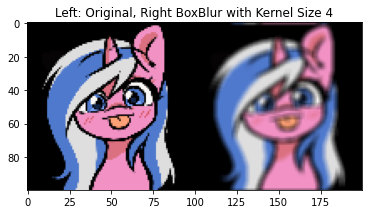

In [24]:
TheImage = ReadImageAsNumpy(".\\data\\image2.png")
TheImage /= 255
# TheImage = np.mean(TheImage, axis=2)
Matrix = TheImage[0:-1:5, 0:-1:5, :3]
N = 2
BoxSize= 5
Height, Width, _ = Matrix.shape
Blurred = BoxBlur(Matrix, boxsize=BoxSize)
ToPlot = np.zeros((Height, Width*2, 3))
ToPlot[:, :Width, :], ToPlot[:, Width:, :] = Matrix, Blurred
plt.imshow(ToPlot)
plt.title(f"Left: Original, Right BoxBlur with Kernel Size {BoxSize}")

---
**Deblur the Image with Conjugate Gradient While Collecting Data**
* Give the black box
* Run the Conjugate Gradient Algorithm
* Get the recovered image

5000it [00:25, 198.44it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


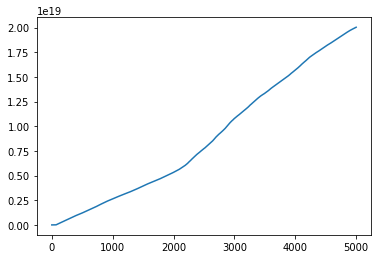

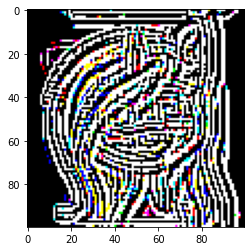

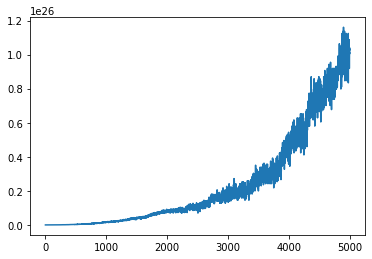

In [25]:
Analyzer = CGAnalyzer(
    lambda x: BoxBlur(x, boxsize=BoxSize),
    Blurred,
    np.ones(Matrix.shape)
)
EnergyNorm = []
for II, (x, r) in tqdm(enumerate(Analyzer.Generate(maxitr=5000))):
    E = x - Matrix
    EnergyNorm.append(
        np.sum(E*BoxBlur(E, boxsize=BoxSize))
    )
    if r < 1e-2:
        break

plt.plot(Analyzer.ResidualNorm)
plt.show()
plt.imshow(Analyzer.BestSolution)
plt.show()
plt.plot(EnergyNorm)
plt.show()

**Energy Norm**
The Energy Norm of the error is not monotonically decreasing, meanin that the matrix is not Positive Definite. Conjugate gradient won't garantee convergence in this case.

But in this case, it worked for some reasons. But in general, it won't work, because if the energy norm of the transformation is negative, it implies that the linear transformation is not positive semidefinite. But in this case I am confident that the matrix is symmetric.